In [2]:
%load_ext autoreload
%autoreload 2
import os 
os.chdir("/home/jadli/Desktop/BDAI2/Satellite_Super_Resulotion0")
import os
import random
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from src.utils.models_architecture import EDSR, SRCNN, Custom_model, SRResNet


/tmp/ipykernel_70821/1598188946.py:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)


✔ SRCNN model loaded successfully


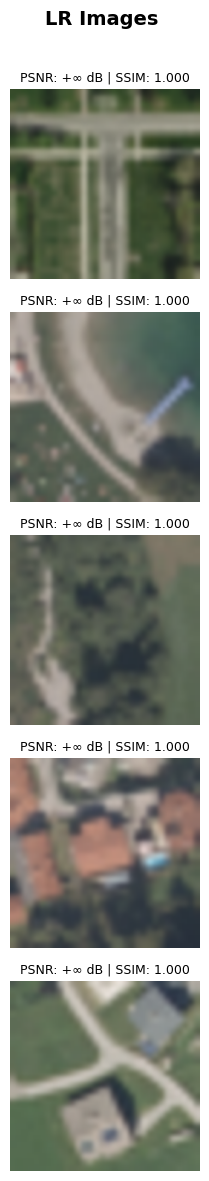

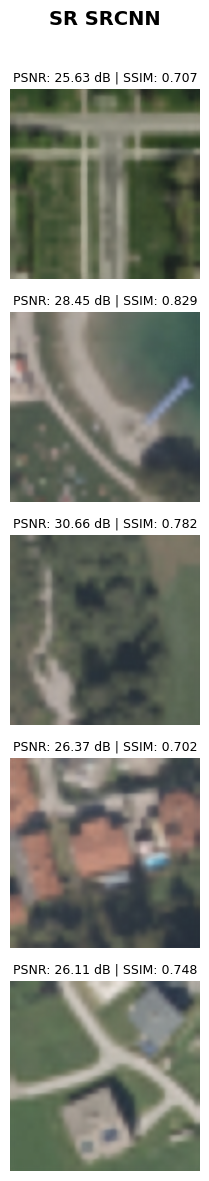

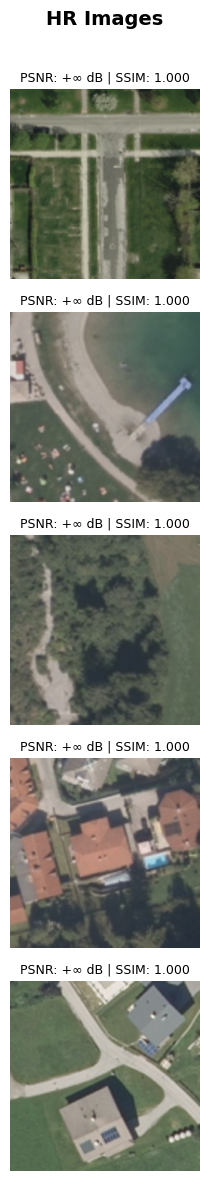

In [ ]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
import numpy as np



# =====================================================
# CONFIGURATION
# =====================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TEST_DIR = "data_test"
HR_DIR = "data/preprocessed/test/HR"
BEST_MODEL_PATH = "MODEL_TEST/best_SRCNN.pth"

SCALE = 4
TARGET_SIZE = (256, 256)   # ⭐ Taille FIXE → reproductibilité

to_tensor = transforms.ToTensor()

# =====================================================
# METRICS
# =====================================================
def compute_psnr(sr, hr):
    mse = torch.mean((sr - hr) ** 2)
    if mse == 0:
        return float("inf")
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def compute_ssim(sr, hr):
    sr_np = sr.squeeze().permute(1, 2, 0).cpu().numpy()
    hr_np = hr.squeeze().permute(1, 2, 0).cpu().numpy()
    return ssim(sr_np, hr_np, channel_axis=2, data_range=1.0)

# =====================================================
# LOAD SRCNN MODEL
# =====================================================
model = SRCNN().to(DEVICE)
ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

print("✔ SRCNN model loaded successfully")

# =====================================================
# LOAD & PROCESS IMAGES
# =====================================================
img_names = sorted(os.listdir(TEST_DIR))

lr_imgs, sr_imgs, hr_imgs = [], [], []
sr_metrics = []

with torch.no_grad():
    for name in img_names:
        # -------- Load images --------
        lr_img = Image.open(os.path.join(TEST_DIR, name)).convert("RGB")
        hr_img = Image.open(os.path.join(HR_DIR, name)).convert("RGB")

        # -------- Resize (reproducible) --------
        lr_up = lr_img.resize(TARGET_SIZE, Image.BICUBIC)
        hr_img = hr_img.resize(TARGET_SIZE, Image.BICUBIC)

        lr = to_tensor(lr_up).unsqueeze(0).to(DEVICE)
        hr = to_tensor(hr_img).unsqueeze(0).to(DEVICE)

        # -------- SRCNN inference --------
        sr = torch.clamp(model(lr), 0.0, 1.0)

        # -------- Metrics --------
        psnr_val = compute_psnr(sr, hr).item()
        ssim_val = compute_ssim(sr, hr)

        # -------- Store --------
        lr_imgs.append(lr_up)
        sr_imgs.append(sr.squeeze().permute(1, 2, 0).cpu())
        hr_imgs.append(hr_img)
        sr_metrics.append((psnr_val, ssim_val))

# =====================================================
# PLOTTING FUNCTIONS
# =====================================================
def plot_lr(images):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.set_title("PSNR: +∞ dB | SSIM: 1.000", fontsize=9)
        ax.axis("off")

    plt.suptitle("LR Images ", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def plot_sr(images, metrics):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img, (p, s) in zip(axes, images, metrics):
        ax.imshow(img)
        ax.set_title(f"PSNR: {p:.2f} dB | SSIM: {s:.3f}", fontsize=9)
        ax.axis("off")

    plt.suptitle("SR SRCNN", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def plot_hr(images):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.set_title("PSNR: +∞ dB | SSIM: 1.000", fontsize=9)
        ax.axis("off")

    plt.suptitle("HR Images", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# =====================================================
# DISPLAY RESULTS
# =====================================================
plot_lr(lr_imgs)
plot_sr(sr_imgs, sr_metrics)
plot_hr(hr_imgs)


/tmp/ipykernel_70821/1671564173.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)


✔ EDSR model loaded successfully


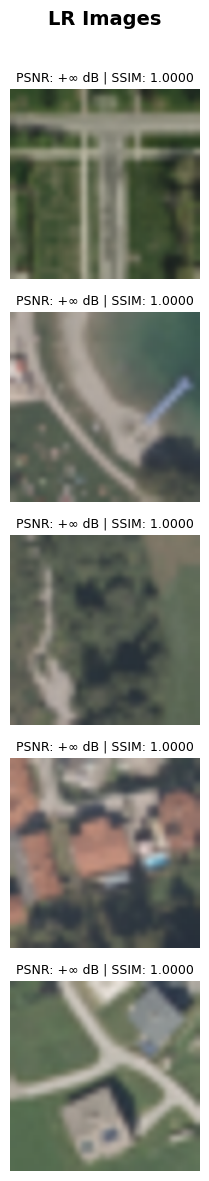

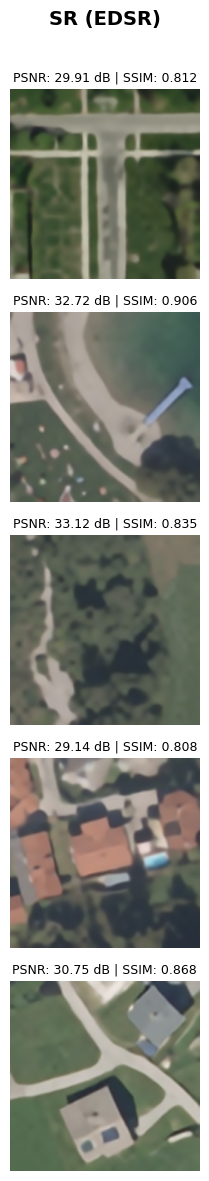

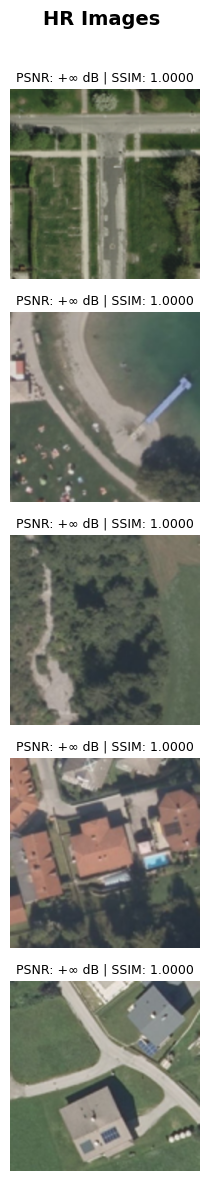

In [22]:
import os
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
import numpy as np

# =====================================================
# CONFIGURATION
# =====================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TEST_DIR = "data_test"
HR_DIR = "data/preprocessed/test/HR"
BEST_MODEL_PATH = "MODEL_TEST/best_EDSR.pth"

SCALE = 4
TARGET_SIZE = (256, 256)   # ⭐ Taille FIXE → reproductibilité

to_tensor = transforms.ToTensor()

# =====================================================
# METRICS
# =====================================================
def compute_psnr(sr, hr):
    mse = torch.mean((sr - hr) ** 2)
    if mse == 0:
        return float("inf")
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def compute_ssim(sr, hr):
    sr_np = sr.squeeze().permute(1, 2, 0).cpu().numpy()
    hr_np = hr.squeeze().permute(1, 2, 0).cpu().numpy()
    return ssim(sr_np, hr_np, channel_axis=2, data_range=1.0)

# =====================================================
# LOAD EDSR MODEL
# =====================================================
model = EDSR(scale_factor=SCALE).to(DEVICE)
ckpt = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
model.eval()

print("✔ EDSR model loaded successfully")

# =====================================================
# LOAD & PROCESS IMAGES
# =====================================================
img_names = sorted(os.listdir(TEST_DIR))

lr_imgs, sr_imgs, hr_imgs = [], [], []
sr_metrics = []

with torch.no_grad():
    for name in img_names:
        # -------- Load images --------
        lr_img = Image.open(os.path.join(TEST_DIR, name)).convert("RGB")
        hr_img = Image.open(os.path.join(HR_DIR, name)).convert("RGB")

        # -------- Resize (reproducible) --------
        # EDSR prend LR et upscale lui-même
        hr_img = hr_img.resize(TARGET_SIZE, Image.BICUBIC)

        lr_tensor = to_tensor(lr_img).unsqueeze(0).to(DEVICE)

        # -------- EDSR inference --------
        sr = torch.clamp(model(lr_tensor), 0.0, 1.0)

        # For comparison / display consistency
        sr = torch.nn.functional.interpolate(
            sr,
            size=TARGET_SIZE,
            mode="bicubic",
            align_corners=False
        )

        hr = to_tensor(hr_img).unsqueeze(0).to(DEVICE)

        # -------- Metrics --------
        psnr_val = compute_psnr(sr, hr).item()
        ssim_val = compute_ssim(sr, hr)

        # -------- Store --------
        lr_imgs.append(
            lr_img.resize(TARGET_SIZE, Image.BICUBIC)
        )
        sr_imgs.append(sr.squeeze().permute(1, 2, 0).cpu())
        hr_imgs.append(hr_img)
        sr_metrics.append((psnr_val, ssim_val))

# =====================================================
# PLOTTING FUNCTIONS
# =====================================================
def plot_lr(images):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.set_title("PSNR: +∞ dB | SSIM: 1.0000", fontsize=9)
        ax.axis("off")

    plt.suptitle("LR Images", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def plot_sr(images, metrics):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img, (p, s) in zip(axes, images, metrics):
        ax.imshow(img)
        ax.set_title(f"PSNR: {p:.2f} dB | SSIM: {s:.3f}", fontsize=9)
        ax.axis("off")

    plt.suptitle("SR (EDSR)", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def plot_hr(images):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.set_title("PSNR: +∞ dB | SSIM: 1.0000", fontsize=9)
        ax.axis("off")

    plt.suptitle("HR Images ", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# =====================================================
# DISPLAY RESULTS
# =====================================================
plot_lr(lr_imgs)
plot_sr(sr_imgs, sr_metrics)
plot_hr(hr_imgs)


/tmp/ipykernel_70821/57847650.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  srcnn.load_state_dict(torch.load(SRCNN_CKPT, map_location=DEVICE)["model"])
/tmp/ipykernel

✔ SRCNN & EDSR loaded


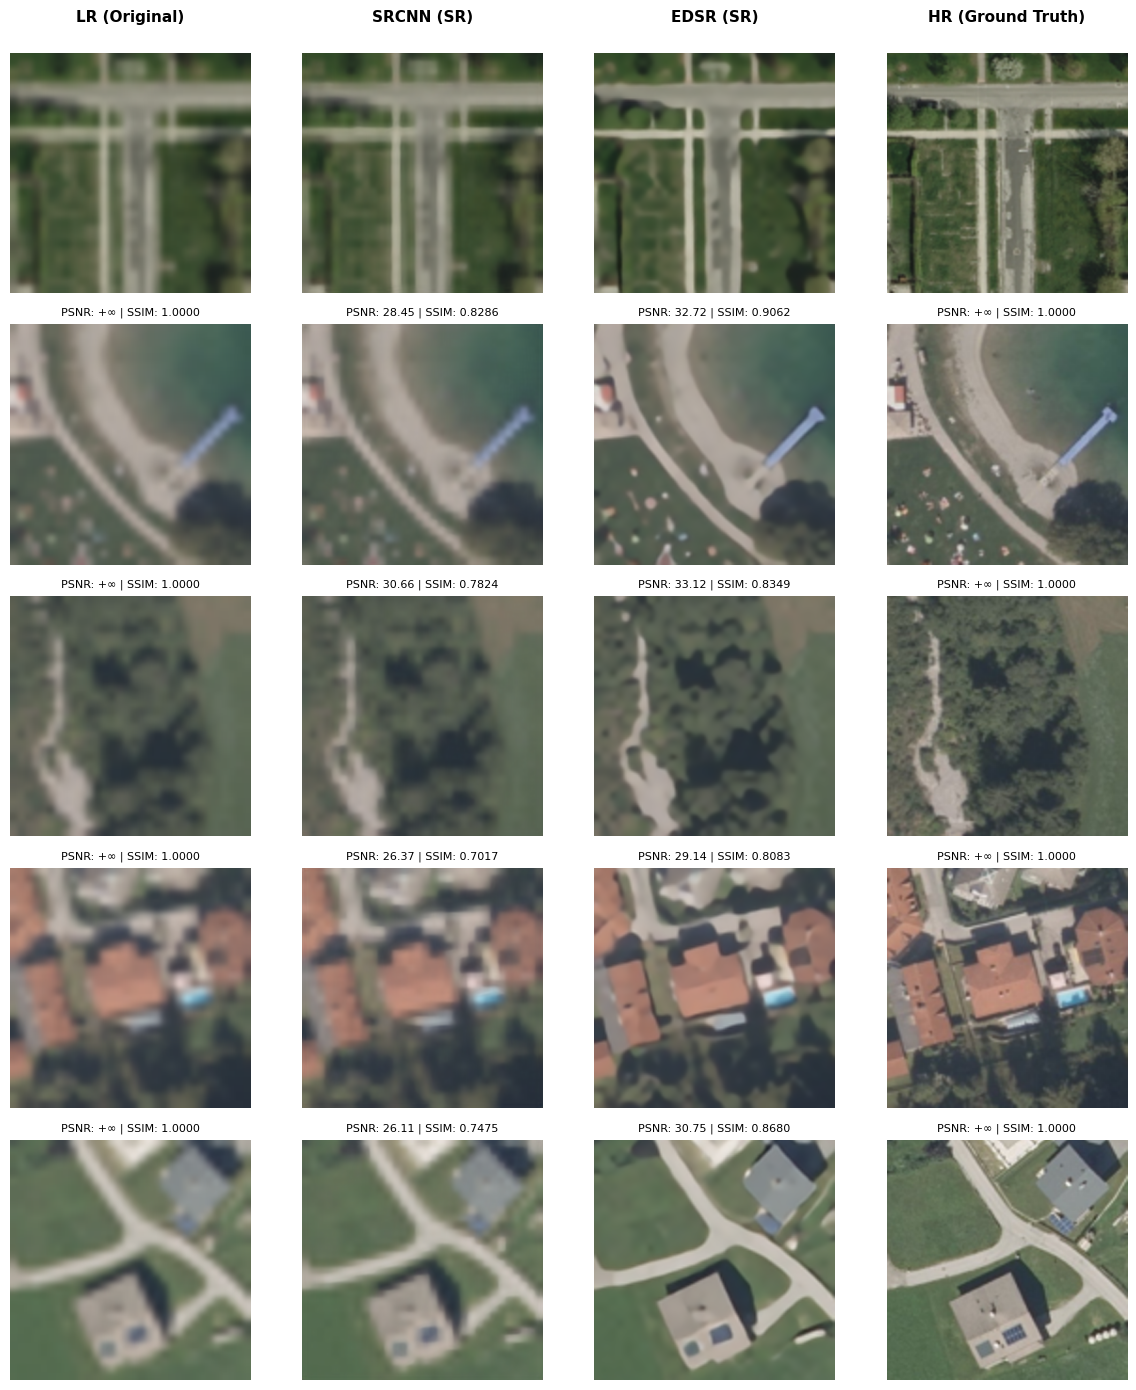

In [23]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim

# =====================================================
# CONFIG
# =====================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TEST_DIR = "data_test"
HR_DIR = "data/preprocessed/test/HR"

SRCNN_CKPT = "MODEL_TEST/best_SRCNN.pth"
EDSR_CKPT  = "MODEL_TEST/best_EDSR.pth"

SCALE = 4
TARGET_SIZE = (256, 256)   # ⭐ reproductibilité

to_tensor = transforms.ToTensor()

# =====================================================
# METRICS
# =====================================================
def compute_psnr(sr, hr):
    mse = torch.mean((sr - hr) ** 2)
    if mse == 0:
        return float("inf")
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def compute_ssim(sr, hr):
    sr_np = sr.squeeze().permute(1, 2, 0).cpu().numpy()
    hr_np = hr.squeeze().permute(1, 2, 0).cpu().numpy()
    return ssim(sr_np, hr_np, channel_axis=2, data_range=1.0)

# =====================================================
# LOAD MODELS
# =====================================================
srcnn = SRCNN().to(DEVICE)
edsr  = EDSR(scale_factor=SCALE).to(DEVICE)

srcnn.load_state_dict(torch.load(SRCNN_CKPT, map_location=DEVICE)["model"])
edsr.load_state_dict(torch.load(EDSR_CKPT,  map_location=DEVICE)["model"])

srcnn.eval()
edsr.eval()

print("✔ SRCNN & EDSR loaded")

# =====================================================
# LOAD IMAGES
# =====================================================
img_names = sorted(os.listdir(TEST_DIR))

LR, SRCNN_SR, EDSR_SR, HR = [], [], [], []
METRICS_SRCNN, METRICS_EDSR = [], []

with torch.no_grad():
    for name in img_names:
        # ---------- LOAD ----------
        lr_img = Image.open(os.path.join(TEST_DIR, name)).convert("RGB")
        hr_img = Image.open(os.path.join(HR_DIR, name)).convert("RGB")

        # ---------- RESIZE ----------
        lr_up = lr_img.resize(TARGET_SIZE, Image.BICUBIC)
        hr_img = hr_img.resize(TARGET_SIZE, Image.BICUBIC)

        lr_tensor = to_tensor(lr_up).unsqueeze(0).to(DEVICE)
        hr_tensor = to_tensor(hr_img).unsqueeze(0).to(DEVICE)

        # ---------- SRCNN ----------
        sr_srcnn = torch.clamp(srcnn(lr_tensor), 0, 1)

        # ---------- EDSR ----------
        lr_native = to_tensor(lr_img).unsqueeze(0).to(DEVICE)
        sr_edsr = torch.clamp(edsr(lr_native), 0, 1)
        sr_edsr = F.interpolate(sr_edsr, size=TARGET_SIZE, mode="bicubic", align_corners=False)

        # ---------- METRICS ----------
        psnr_s = compute_psnr(sr_srcnn, hr_tensor).item()
        ssim_s = compute_ssim(sr_srcnn, hr_tensor)

        psnr_e = compute_psnr(sr_edsr, hr_tensor).item()
        ssim_e = compute_ssim(sr_edsr, hr_tensor)

        # ---------- STORE ----------
        LR.append(lr_up)
        SRCNN_SR.append(sr_srcnn.squeeze().permute(1, 2, 0).cpu())
        EDSR_SR.append(sr_edsr.squeeze().permute(1, 2, 0).cpu())
        HR.append(hr_img)

        METRICS_SRCNN.append((psnr_s, ssim_s))
        METRICS_EDSR.append((psnr_e, ssim_e))

# =====================================================
# PLOT FINAL FIGURE
# =====================================================
fig, axes = plt.subplots(len(img_names), 4, figsize=(12, 14))

for i in range(len(img_names)):
    # LR
    axes[i, 0].imshow(LR[i])
    axes[i, 0].set_title("PSNR: +∞ | SSIM: 1.0000", fontsize=8)
    axes[i, 0].axis("off")

    # SRCNN
    p, s = METRICS_SRCNN[i]
    axes[i, 1].imshow(SRCNN_SR[i])
    axes[i, 1].set_title(f"PSNR: {p:.2f} | SSIM: {s:.4f}", fontsize=8)
    axes[i, 1].axis("off")

    # EDSR
    p, s = METRICS_EDSR[i]
    axes[i, 2].imshow(EDSR_SR[i])
    axes[i, 2].set_title(f"PSNR: {p:.2f} | SSIM: {s:.4f}", fontsize=8)
    axes[i, 2].axis("off")

    # HR
    axes[i, 3].imshow(HR[i])
    axes[i, 3].set_title("PSNR: +∞ | SSIM: 1.0000", fontsize=8)
    axes[i, 3].axis("off")

# Column headers
titles = [
    "LR (Original)",
    "SRCNN (SR)",
    "EDSR (SR)",
    "HR (Ground Truth)"
]
for j, t in enumerate(titles):
    axes[0, j].set_title(t, fontsize=11, fontweight="bold", pad=22)

plt.tight_layout()
plt.show()


/tmp/ipykernel_70821/860219900.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CUSTOM_CKPT, map_location=DEVICE)


✔ Custom SR model loaded


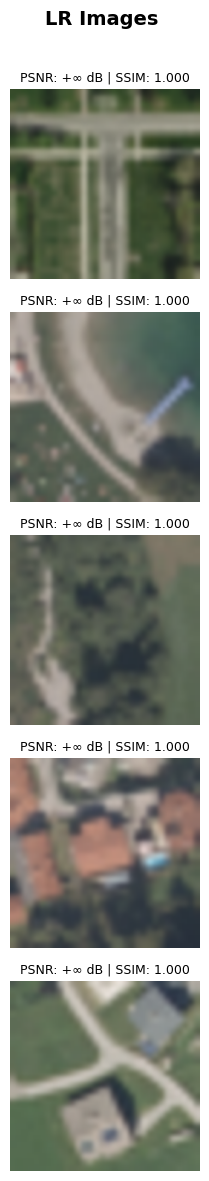

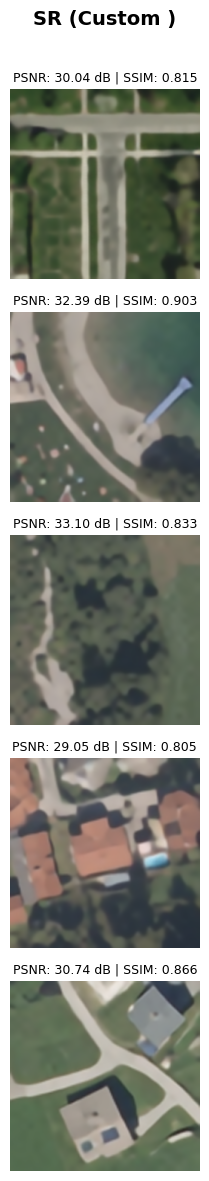

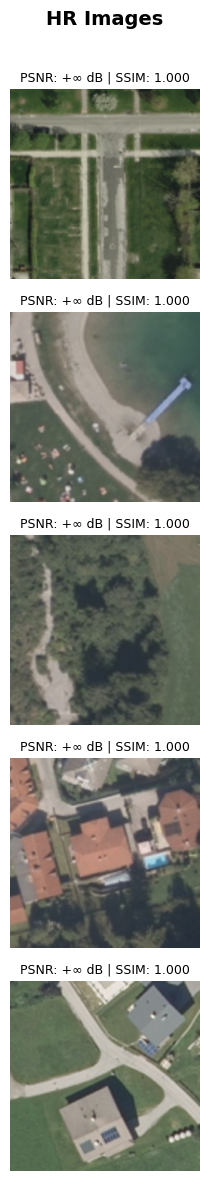

In [29]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim

# =====================================================
# CONFIG
# =====================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TEST_DIR = "data_test"
HR_DIR = "data/preprocessed/test/HR"
CUSTOM_CKPT = "MODEL_TEST/best_custom_with_L1loss.pth"

SCALE = 4
TARGET_SIZE = (256, 256)   # ⭐ reproductibilité

to_tensor = transforms.ToTensor()

# =====================================================
# METRICS
# =====================================================
def compute_psnr(sr, hr):
    mse = torch.mean((sr - hr) ** 2)
    if mse == 0:
        return float("inf")
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def compute_ssim(sr, hr):
    sr_np = sr.squeeze().permute(1, 2, 0).cpu().numpy()
    hr_np = hr.squeeze().permute(1, 2, 0).cpu().numpy()
    return ssim(sr_np, hr_np, channel_axis=2, data_range=1.0)

# =====================================================
# LOAD CUSTOM MODEL
# =====================================================
model = Custom_model(n_HF_blocks=12,n_MS_blocks=4,n_LF_blocks=20).to(DEVICE)

ckpt = torch.load(CUSTOM_CKPT, map_location=DEVICE)

# compatible avec {"model": state_dict} ou state_dict direct
state_dict = ckpt["model"] if "model" in ckpt else ckpt
model.load_state_dict(state_dict)

model.eval()
print("✔ Custom SR model loaded")

# =====================================================
# LOAD & PROCESS IMAGES
# =====================================================
img_names = sorted(os.listdir(TEST_DIR))

lr_imgs, sr_imgs, hr_imgs = [], [], []
sr_metrics = []

with torch.no_grad():
    for name in img_names:
        # ---------- LOAD ----------
        lr_img = Image.open(os.path.join(TEST_DIR, name)).convert("RGB")
        hr_img = Image.open(os.path.join(HR_DIR, name)).convert("RGB")

        # ---------- RESIZE (REFERENCE SIZE) ----------
        hr_img = hr_img.resize(TARGET_SIZE, Image.BICUBIC)

        lr_tensor = to_tensor(lr_img).unsqueeze(0).to(DEVICE)
        hr_tensor = to_tensor(hr_img).unsqueeze(0).to(DEVICE)

        # ---------- CUSTOM MODEL ----------
        sr = torch.clamp(model(lr_tensor), 0, 1)

        # Force same spatial size (safety)
        sr = F.interpolate(
            sr,
            size=TARGET_SIZE,
            mode="bicubic",
            align_corners=False
        )

        # ---------- METRICS ----------
        psnr_val = compute_psnr(sr, hr_tensor).item()
        ssim_val = compute_ssim(sr, hr_tensor)

        # ---------- STORE ----------
        lr_imgs.append(
            lr_img.resize(TARGET_SIZE, Image.BICUBIC)
        )
        sr_imgs.append(sr.squeeze().permute(1, 2, 0).cpu())
        hr_imgs.append(hr_img)
        sr_metrics.append((psnr_val, ssim_val))

# =====================================================
# PLOTTING FUNCTIONS
# =====================================================
def plot_lr(images):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.set_title("PSNR: +∞ dB | SSIM: 1.000", fontsize=9)
        ax.axis("off")
    plt.suptitle("LR Images ", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def plot_sr(images, metrics):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img, (p, s) in zip(axes, images, metrics):
        ax.imshow(img)
        ax.set_title(f"PSNR: {p:.2f} dB | SSIM: {s:.3f}", fontsize=9)
        ax.axis("off")
    plt.suptitle("SR (Custom )", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def plot_hr(images):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.set_title("PSNR: +∞ dB | SSIM: 1.000", fontsize=9)
        ax.axis("off")
    plt.suptitle("HR Images", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# =====================================================
# DISPLAY
# =====================================================
plot_lr(lr_imgs)
plot_sr(sr_imgs, sr_metrics)
plot_hr(hr_imgs)


/tmp/ipykernel_4886/4007348105.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(CUSTOM_CKPT, map_location=DEVICE)


✔ Custom SR model (Perceptual Loss) loaded


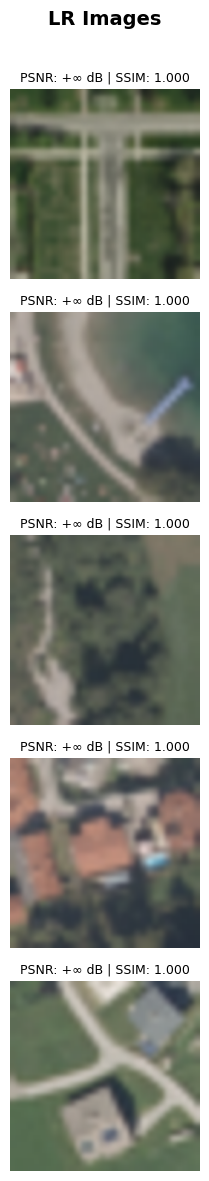

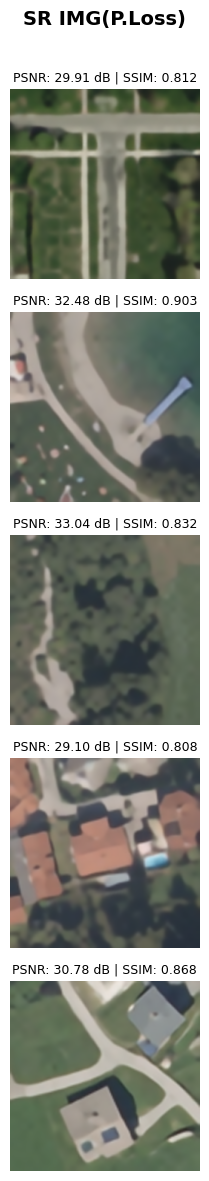

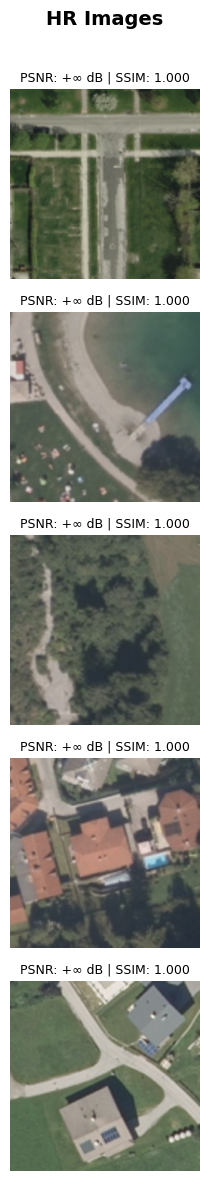

In [6]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim

# =====================================================
# CONFIG
# =====================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TEST_DIR = "data_test"
HR_DIR = "data/preprocessed/test/HR"
CUSTOM_CKPT = "MODEL_TEST/best_custom_with_Perceptual_loss.pth"

SCALE = 4
TARGET_SIZE = (256, 256)   # ⭐ reproductibilité

to_tensor = transforms.ToTensor()

# =====================================================
# METRICS
# =====================================================
def compute_psnr(sr, hr):
    mse = torch.mean((sr - hr) ** 2)
    if mse == 0:
        return float("inf")
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def compute_ssim(sr, hr):
    sr_np = sr.squeeze().permute(1, 2, 0).cpu().numpy()
    hr_np = hr.squeeze().permute(1, 2, 0).cpu().numpy()
    return ssim(sr_np, hr_np, channel_axis=2, data_range=1.0)

# =====================================================
# LOAD CUSTOM MODEL (PERCEPTUAL LOSS)
# =====================================================
model = Custom_model(n_HF_blocks=12,n_MS_blocks=4,n_LF_blocks=20).to(DEVICE)

ckpt = torch.load(CUSTOM_CKPT, map_location=DEVICE)
state_dict = ckpt["model"] if "model" in ckpt else ckpt
model.load_state_dict(state_dict)

model.eval()
print("✔ Custom SR model (Perceptual Loss) loaded")

# =====================================================
# LOAD & PROCESS IMAGES
# =====================================================
img_names = sorted(os.listdir(TEST_DIR))

lr_imgs, sr_imgs, hr_imgs = [], [], []
sr_metrics = []

with torch.no_grad():
    for name in img_names:
        # ---------- LOAD ----------
        lr_img = Image.open(os.path.join(TEST_DIR, name)).convert("RGB")
        hr_img = Image.open(os.path.join(HR_DIR, name)).convert("RGB")

        # ---------- REFERENCE SIZE ----------
        hr_img = hr_img.resize(TARGET_SIZE, Image.BICUBIC)

        lr_tensor = to_tensor(lr_img).unsqueeze(0).to(DEVICE)
        hr_tensor = to_tensor(hr_img).unsqueeze(0).to(DEVICE)

        # ---------- CUSTOM MODEL ----------
        sr = torch.clamp(model(lr_tensor), 0, 1)

        # Safety resize (same size everywhere)
        sr = F.interpolate(
            sr,
            size=TARGET_SIZE,
            mode="bicubic",
            align_corners=False
        )

        # ---------- METRICS ----------
        psnr_val = compute_psnr(sr, hr_tensor).item()
        ssim_val = compute_ssim(sr, hr_tensor)

        # ---------- STORE ----------
        lr_imgs.append(lr_img.resize(TARGET_SIZE, Image.BICUBIC))
        sr_imgs.append(sr.squeeze().permute(1, 2, 0).cpu())
        hr_imgs.append(hr_img)
        sr_metrics.append((psnr_val, ssim_val))

# =====================================================
# PLOTTING FUNCTIONS
# =====================================================
def plot_lr(images):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.set_title("PSNR: +∞ dB | SSIM: 1.000", fontsize=9)
        ax.axis("off")
    plt.suptitle("LR Images", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def plot_sr(images, metrics):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img, (p, s) in zip(axes, images, metrics):
        ax.imshow(img)
        ax.set_title(f"PSNR: {p:.2f} dB | SSIM: {s:.3f}", fontsize=9)
        ax.axis("off")
    plt.suptitle(
        "SR IMG(P.Loss)",
        fontsize=14,
        fontweight="bold"
    )
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def plot_hr(images):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.set_title("PSNR: +∞ dB | SSIM: 1.000", fontsize=9)
        ax.axis("off")
    plt.suptitle("HR Images", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# =====================================================
# DISPLAY
# =====================================================
plot_lr(lr_imgs)
plot_sr(sr_imgs, sr_metrics)
plot_hr(hr_imgs)


/tmp/ipykernel_4886/3499112312.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(SRESNET_CKPT, map_location=DEVICE)


✔ SRResNet model loaded successfully


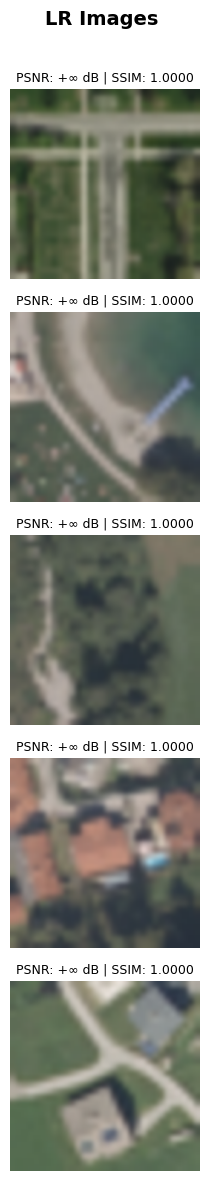

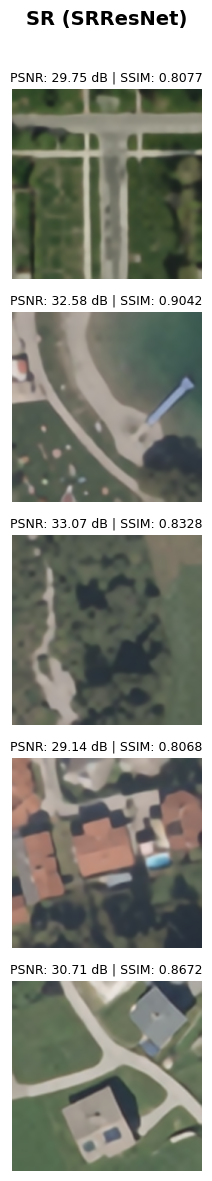

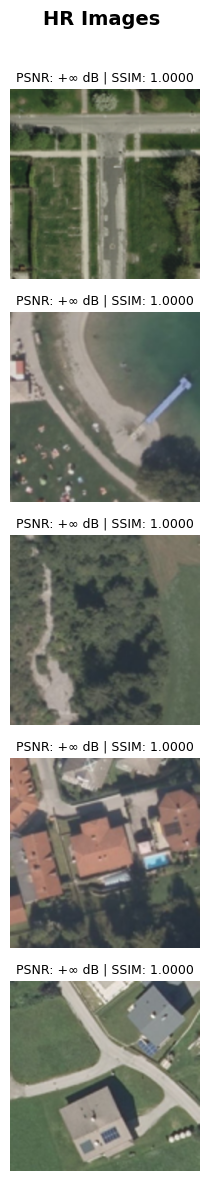

In [7]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim

# =====================================================
# CONFIGURATION
# =====================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TEST_DIR = "data_test"
HR_DIR = "data/preprocessed/test/HR"
SRESNET_CKPT = "MODEL_TEST/best_SRESNET.pth"

SCALE = 4
TARGET_SIZE = (256, 256)   # ⭐ reproductibilité

to_tensor = transforms.ToTensor()

# =====================================================
# METRICS
# =====================================================
def compute_psnr(sr, hr):
    mse = torch.mean((sr - hr) ** 2)
    if mse == 0:
        return float("inf")
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def compute_ssim(sr, hr):
    sr_np = sr.squeeze().permute(1, 2, 0).cpu().numpy()
    hr_np = hr.squeeze().permute(1, 2, 0).cpu().numpy()
    return ssim(sr_np, hr_np, channel_axis=2, data_range=1.0)

# =====================================================
# LOAD SRRESNET MODEL
# =====================================================
model = SRResNet().to(DEVICE)

ckpt = torch.load(SRESNET_CKPT, map_location=DEVICE)
state_dict = ckpt["model"] if "model" in ckpt else ckpt
model.load_state_dict(state_dict)

model.eval()
print("✔ SRResNet model loaded successfully")

# =====================================================
# LOAD & PROCESS IMAGES
# =====================================================
img_names = sorted(os.listdir(TEST_DIR))

lr_imgs, sr_imgs, hr_imgs = [], [], []
sr_metrics = []

with torch.no_grad():
    for name in img_names:
        # ---------- LOAD ----------
        lr_img = Image.open(os.path.join(TEST_DIR, name)).convert("RGB")
        hr_img = Image.open(os.path.join(HR_DIR, name)).convert("RGB")

        # ---------- REFERENCE SIZE ----------
        hr_img = hr_img.resize(TARGET_SIZE, Image.BICUBIC)

        lr_tensor = to_tensor(lr_img).unsqueeze(0).to(DEVICE)
        hr_tensor = to_tensor(hr_img).unsqueeze(0).to(DEVICE)

        # ---------- SRRESNET ----------
        sr = torch.clamp(model(lr_tensor), 0, 1)

        # Safety resize (ensure same size)
        sr = F.interpolate(
            sr,
            size=TARGET_SIZE,
            mode="bicubic",
            align_corners=False
        )

        # ---------- METRICS ----------
        psnr_val = compute_psnr(sr, hr_tensor).item()
        ssim_val = compute_ssim(sr, hr_tensor)

        # ---------- STORE ----------
        lr_imgs.append(lr_img.resize(TARGET_SIZE, Image.BICUBIC))
        sr_imgs.append(sr.squeeze().permute(1, 2, 0).cpu())
        hr_imgs.append(hr_img)
        sr_metrics.append((psnr_val, ssim_val))

# =====================================================
# PLOTTING FUNCTIONS
# =====================================================
def plot_lr(images):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.set_title("PSNR: +∞ dB | SSIM: 1.0000", fontsize=9)
        ax.axis("off")
    plt.suptitle("LR Images ", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def plot_sr(images, metrics):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img, (p, s) in zip(axes, images, metrics):
        ax.imshow(img)
        ax.set_title(f"PSNR: {p:.2f} dB | SSIM: {s:.4f}", fontsize=9)
        ax.axis("off")
    plt.suptitle("SR (SRResNet)", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

def plot_hr(images):
    fig, axes = plt.subplots(len(images), 1, figsize=(4, 12))
    for ax, img in zip(axes, images):
        ax.imshow(img)
        ax.set_title("PSNR: +∞ dB | SSIM: 1.0000", fontsize=9)
        ax.axis("off")
    plt.suptitle("HR Images ", fontsize=14, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# =====================================================
# DISPLAY RESULTS
# =====================================================
plot_lr(lr_imgs)
plot_sr(sr_imgs, sr_metrics)
plot_hr(hr_imgs)


/tmp/ipykernel_4886/3103492675.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path, map_location=DEVICE)


✔ All models loaded: SRCNN | SRResNet | EDSR | Custom-L1 | Custom-Perceptual


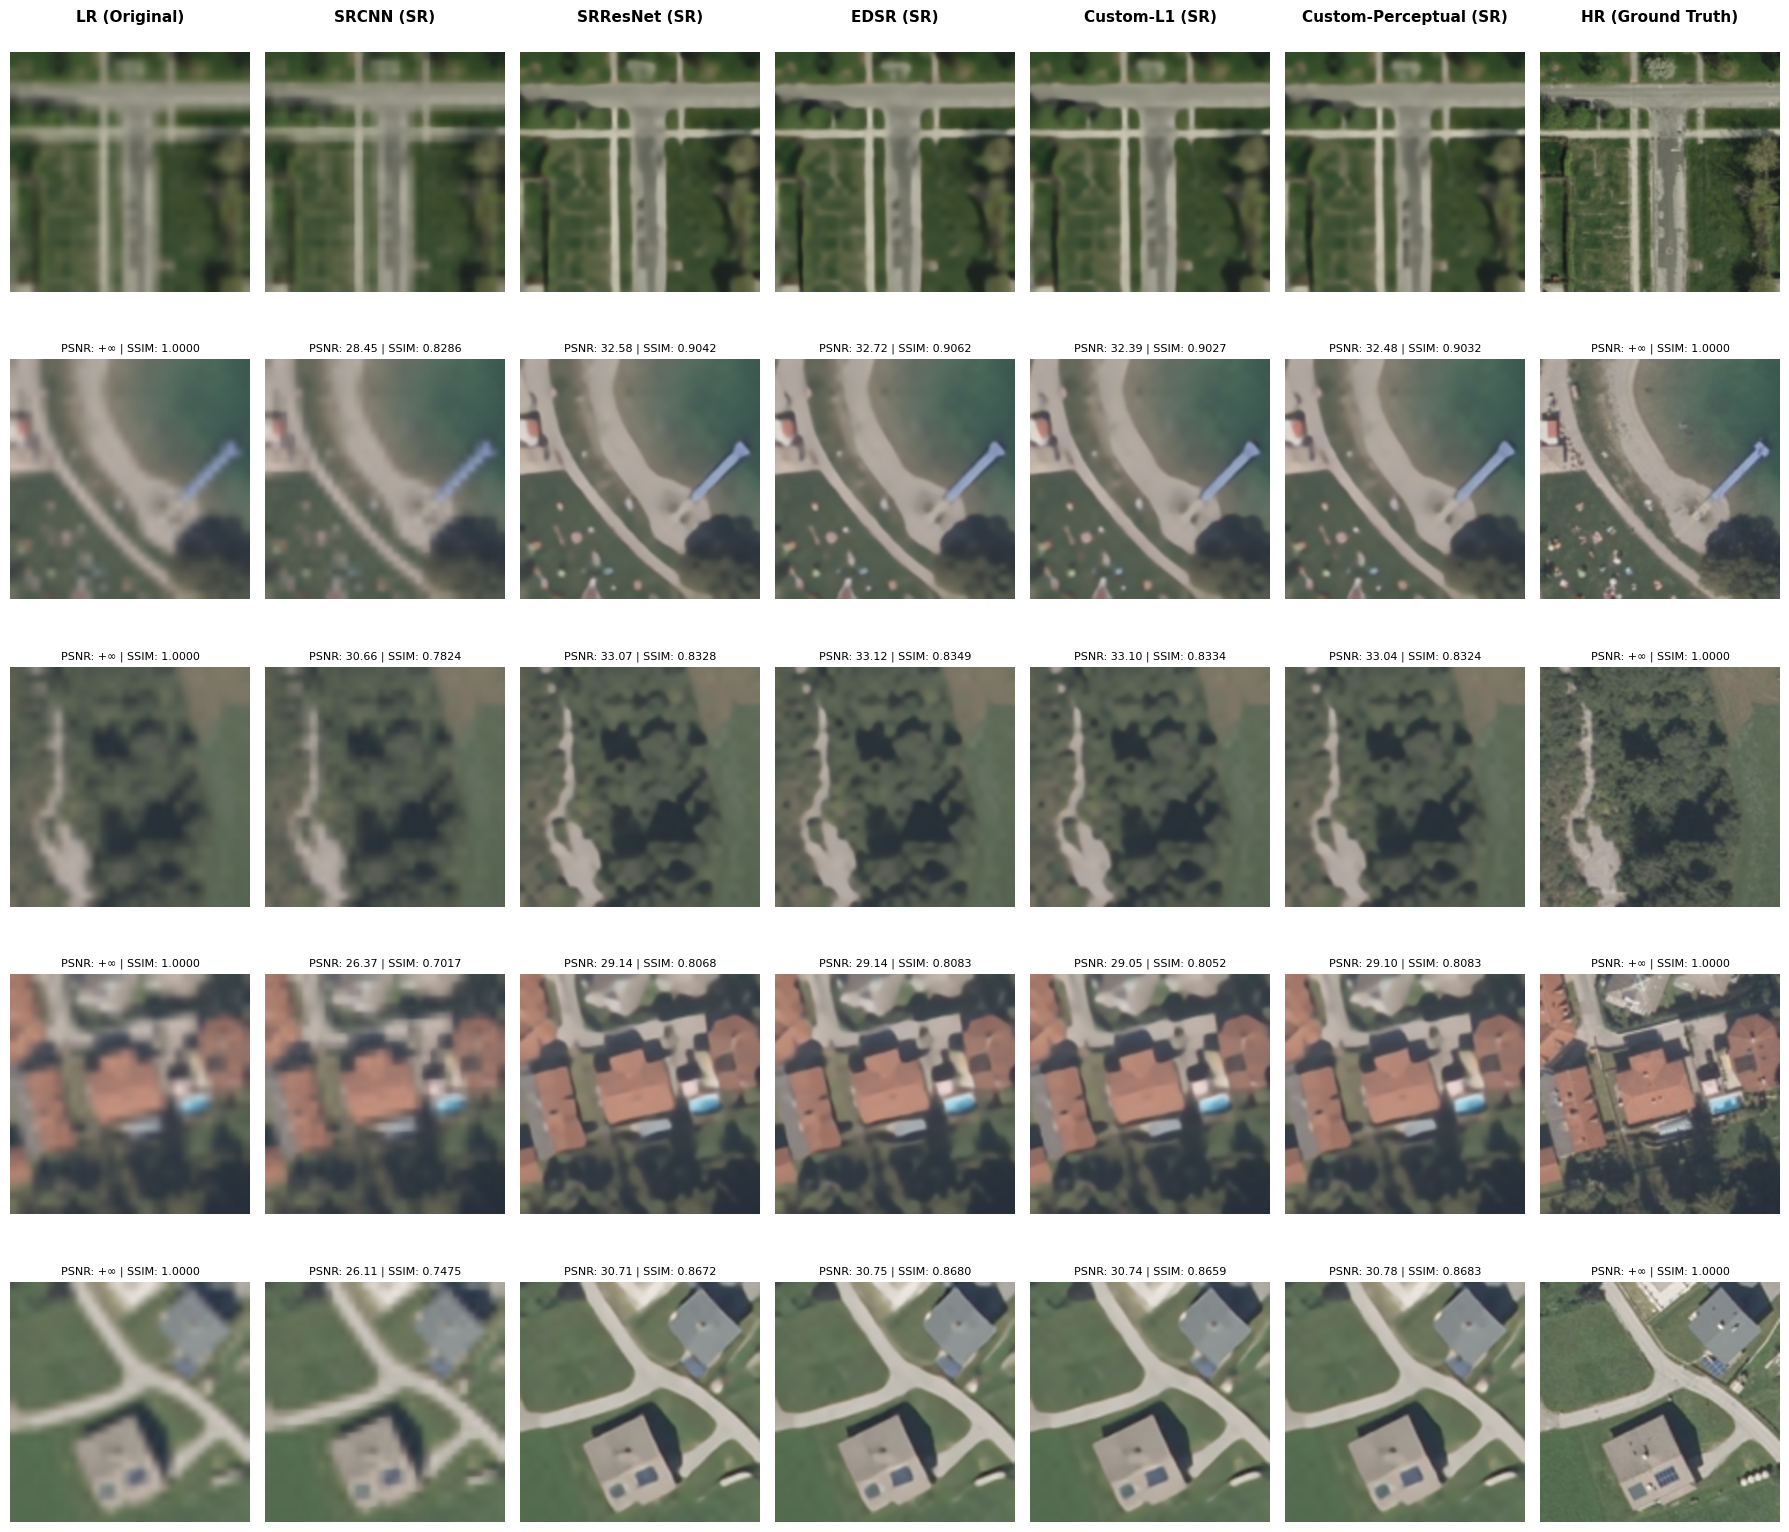

In [9]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim

# =====================================================
# CONFIG
# =====================================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

TEST_DIR = "data_test"
HR_DIR   = "data/preprocessed/test/HR"

CKPT_SRCNN   = "MODEL_TEST/best_SRCNN.pth"
CKPT_SRESNET = "MODEL_TEST/best_SRESNET.pth"
CKPT_EDSR    = "MODEL_TEST/best_EDSR.pth"
CKPT_CUST_L1 = "MODEL_TEST/best_custom_with_L1loss.pth"
CKPT_CUST_P  = "MODEL_TEST/best_custom_with_Perceptual_loss.pth"

SCALE = 4
TARGET_SIZE = (256, 256)   # ⭐ reproductibilité (fixe)
to_tensor = transforms.ToTensor()

# =====================================================
# METRICS
# =====================================================
def compute_psnr(sr, hr):
    mse = torch.mean((sr - hr) ** 2)
    if mse == 0:
        return float("inf")
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def compute_ssim(sr, hr):
    sr_np = sr.squeeze().permute(1, 2, 0).cpu().numpy()
    hr_np = hr.squeeze().permute(1, 2, 0).cpu().numpy()
    return ssim(sr_np, hr_np, channel_axis=2, data_range=1.0)

def load_state(path):
    ckpt = torch.load(path, map_location=DEVICE)
    return ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt

# =====================================================
# LOAD MODELS
# =====================================================
srcnn = SRCNN().to(DEVICE)
srcnn.load_state_dict(load_state(CKPT_SRCNN))
srcnn.eval()

srresnet = SRResNet().to(DEVICE)
srresnet.load_state_dict(load_state(CKPT_SRESNET))
srresnet.eval()

edsr = EDSR().to(DEVICE)
edsr.load_state_dict(load_state(CKPT_EDSR))
edsr.eval()

cust_l1 = Custom_model(n_HF_blocks=12,n_MS_blocks=4,n_LF_blocks=20).to(DEVICE)
cust_l1.load_state_dict(load_state(CKPT_CUST_L1))
cust_l1.eval()

cust_p = Custom_model(n_HF_blocks=12,n_MS_blocks=4,n_LF_blocks=20).to(DEVICE)
cust_p.load_state_dict(load_state(CKPT_CUST_P))
cust_p.eval()

print("✔ All models loaded: SRCNN | SRResNet | EDSR | Custom-L1 | Custom-Perceptual")

# =====================================================
# LOAD IMAGES LIST (fixed, no random)
# =====================================================
img_names = sorted(os.listdir(TEST_DIR))
# Optionnel: si tu veux forcer 5 images max
img_names = img_names[:5]

# Storage
LR_imgs, HR_imgs = [], []
SRCNN_imgs, SRESNET_imgs, EDSR_imgs, CUSTL1_imgs, CUSTP_imgs = [], [], [], [], []
M_SRCNN, M_SRESNET, M_EDSR, M_CUSTL1, M_CUSTP = [], [], [], [], []

# =====================================================
# INFERENCE
# =====================================================
with torch.no_grad():
    for name in img_names:
        # ----- Load -----
        lr_img_raw = Image.open(os.path.join(TEST_DIR, name)).convert("RGB")
        hr_img = Image.open(os.path.join(HR_DIR, name)).convert("RGB")

        # ----- Reference HR size (fixed) -----
        hr_img = hr_img.resize(TARGET_SIZE, Image.BICUBIC)
        hr = to_tensor(hr_img).unsqueeze(0).to(DEVICE)

        # ----- LR displayed (fixed size) -----
        lr_disp = lr_img_raw.resize(TARGET_SIZE, Image.BICUBIC)
        LR_imgs.append(lr_disp)
        HR_imgs.append(hr_img)

        # =================================================
        # 1) SRCNN: needs bicubic-upsampled LR as input
        # =================================================
        lr_srcnn = lr_img_raw.resize(TARGET_SIZE, Image.BICUBIC)
        lr_srcnn_t = to_tensor(lr_srcnn).unsqueeze(0).to(DEVICE)
        sr_srcnn = torch.clamp(srcnn(lr_srcnn_t), 0, 1)
        sr_srcnn = F.interpolate(sr_srcnn, size=TARGET_SIZE, mode="bicubic", align_corners=False)

        psnr_v = compute_psnr(sr_srcnn, hr).item()
        ssim_v = compute_ssim(sr_srcnn, hr)
        SRCNN_imgs.append(sr_srcnn.squeeze().permute(1, 2, 0).cpu())
        M_SRCNN.append((psnr_v, ssim_v))

        # =================================================
        # 2) SRResNet: internal upsampling
        # =================================================
        lr_native = to_tensor(lr_img_raw).unsqueeze(0).to(DEVICE)
        sr_sres = torch.clamp(srresnet(lr_native), 0, 1)
        sr_sres = F.interpolate(sr_sres, size=TARGET_SIZE, mode="bicubic", align_corners=False)

        psnr_v = compute_psnr(sr_sres, hr).item()
        ssim_v = compute_ssim(sr_sres, hr)
        SRESNET_imgs.append(sr_sres.squeeze().permute(1, 2, 0).cpu())
        M_SRESNET.append((psnr_v, ssim_v))

        # =================================================
        # 3) EDSR: internal upsampling
        # =================================================
        sr_edsr = torch.clamp(edsr(lr_native), 0, 1)
        sr_edsr = F.interpolate(sr_edsr, size=TARGET_SIZE, mode="bicubic", align_corners=False)

        psnr_v = compute_psnr(sr_edsr, hr).item()
        ssim_v = compute_ssim(sr_edsr, hr)
        EDSR_imgs.append(sr_edsr.squeeze().permute(1, 2, 0).cpu())
        M_EDSR.append((psnr_v, ssim_v))

        # =================================================
        # 4) Custom-L1: internal (your forward already adds bicubic baseline)
        # =================================================
        sr_c1 = torch.clamp(cust_l1(lr_native), 0, 1)
        sr_c1 = F.interpolate(sr_c1, size=TARGET_SIZE, mode="bicubic", align_corners=False)

        psnr_v = compute_psnr(sr_c1, hr).item()
        ssim_v = compute_ssim(sr_c1, hr)
        CUSTL1_imgs.append(sr_c1.squeeze().permute(1, 2, 0).cpu())
        M_CUSTL1.append((psnr_v, ssim_v))

        # =================================================
        # 5) Custom-Perceptual
        # =================================================
        sr_cp = torch.clamp(cust_p(lr_native), 0, 1)
        sr_cp = F.interpolate(sr_cp, size=TARGET_SIZE, mode="bicubic", align_corners=False)

        psnr_v = compute_psnr(sr_cp, hr).item()
        ssim_v = compute_ssim(sr_cp, hr)
        CUSTP_imgs.append(sr_cp.squeeze().permute(1, 2, 0).cpu())
        M_CUSTP.append((psnr_v, ssim_v))

# =====================================================
# PLOT FINAL GRID: 7 columns x N rows
# =====================================================
col_titles = [
    "LR (Original)",
    "SRCNN (SR)",
    "SRResNet (SR)",
    "EDSR (SR)",
    "Custom-L1 (SR)",
    "Custom-Perceptual (SR)",
    "HR (Ground Truth)"
]

n = len(img_names)
fig, axes = plt.subplots(n, 7, figsize=(18, 3.2 * n))

if n == 1:
    axes = axes.reshape(1, 7)

for i in range(n):
    # LR
    axes[i, 0].imshow(LR_imgs[i])
    axes[i, 0].set_title("PSNR: +∞ | SSIM: 1.0000", fontsize=8)
    axes[i, 0].axis("off")

    # SRCNN
    p, s = M_SRCNN[i]
    axes[i, 1].imshow(SRCNN_imgs[i])
    axes[i, 1].set_title(f"PSNR: {p:.2f} | SSIM: {s:.4f}", fontsize=8)
    axes[i, 1].axis("off")

    # SRResNet
    p, s = M_SRESNET[i]
    axes[i, 2].imshow(SRESNET_imgs[i])
    axes[i, 2].set_title(f"PSNR: {p:.2f} | SSIM: {s:.4f}", fontsize=8)
    axes[i, 2].axis("off")

    # EDSR
    p, s = M_EDSR[i]
    axes[i, 3].imshow(EDSR_imgs[i])
    axes[i, 3].set_title(f"PSNR: {p:.2f} | SSIM: {s:.4f}", fontsize=8)
    axes[i, 3].axis("off")

    # Custom-L1
    p, s = M_CUSTL1[i]
    axes[i, 4].imshow(CUSTL1_imgs[i])
    axes[i, 4].set_title(f"PSNR: {p:.2f} | SSIM: {s:.4f}", fontsize=8)
    axes[i, 4].axis("off")

    # Custom-Perceptual
    p, s = M_CUSTP[i]
    axes[i, 5].imshow(CUSTP_imgs[i])
    axes[i, 5].set_title(f"PSNR: {p:.2f} | SSIM: {s:.4f}", fontsize=8)
    axes[i, 5].axis("off")

    # HR
    axes[i, 6].imshow(HR_imgs[i])
    axes[i, 6].set_title("PSNR: +∞ | SSIM: 1.0000", fontsize=8)
    axes[i, 6].axis("off")

# Column headers (top)
for j, t in enumerate(col_titles):
    axes[0, j].set_title(t, fontsize=11, fontweight="bold", pad=22)

plt.tight_layout()
plt.show()
